In [1]:
!pip install covid19-supermarket-abm

In [3]:
import networkx as nx
import matplotlib.pyplot as plt 
from covid19_supermarket_abm.utils.load_example_data import load_example_store_graph
from covid19_supermarket_abm.utils.create_synthetic_baskets import get_all_shortest_path_dicts
from covid19_supermarket_abm.path_generators import get_path_generator
from covid19_supermarket_abm.simulator import simulate_several_days
from covid19_supermarket_abm.simulator import simulate_one_day
from covid19_supermarket_abm.utils.create_store_network import create_store_network

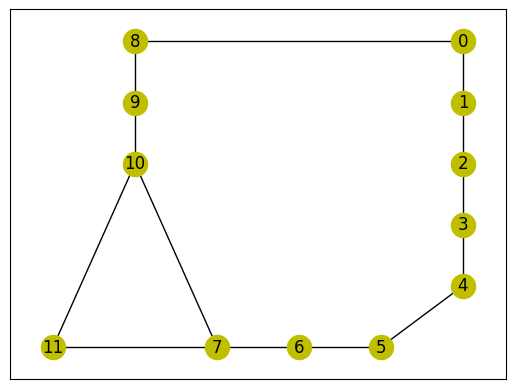

In [7]:
pos = {0: (5,5), 1: (5,4), 2: (5,3), 3: (5,2), 4:(5,1), 5:(4, 0), 6:(3, 0), 7:(2,0), 8:(1, 5), 9:(1, 4), 10:(1, 3), 11:(0,0)}
edges = [(0,1), (1,2), (2,3), (3, 4), (4,5), (5,6), (6,7), (7,10), (8,9), (9,10), (10,11), (7,11), (0,8)]
dh_graph = create_store_network(pos=pos, edges=edges)

nx.draw_networkx(dh_graph, pos=pos, node_color="y")

In [8]:
# Create a path generator which feeds our model with customer paths
entrance_nodes = [0]
till_nodes = [10]
exit_nodes = [11]
item_nodes = [1, 2, 3, 4, 5, 6, 7, 8, 9]
mu = 0.07
sigma = 0.76
shortest_path_dict = get_all_shortest_path_dicts(dh_graph)
synthetic_path_generator_args = [mu, sigma, entrance_nodes, till_nodes, exit_nodes, item_nodes, shortest_path_dict]
path_generator_function, path_generator_args = get_path_generator(path_generation='synthetic',
                                                           synthetic_path_generator_args=synthetic_path_generator_args)

In [11]:
config = {'arrival_rate': 2.55,  # Poisson rate at which customers arrive
           'traversal_time': 0.2,  # mean wait time per node
           'num_hours_open': 10,  # store opening hours
           'infection_proportion': 0.0011,  # proportion of customers that are infectious
         }

# Simulate several days and store results in results
num_days = 50
results = simulate_several_days(config, dh_graph, path_generator_function, path_generator_args, num_iterations=num_days)

100%|██████████| 50/50 [00:10<00:00,  4.57it/s]


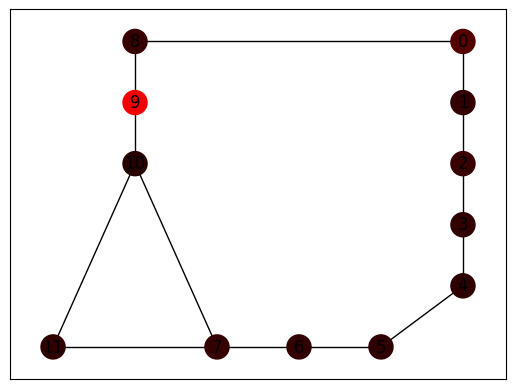

In [12]:
exposures = results[2].mean(0)
nx.draw_networkx(dh_graph, pos=pos, node_color=[(exposure, 0, 0) for exposure in exposures])
